# **San Francisco Crime Analysis & Prediction**




# Gliederung

<!-- 
    Frame the problem and look at the big picture.
    Get the data.
    Explore the data to gain insights.
    Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
    Explore many different models and short-list the best ones.
    Fine-tune your models and combine them into a great solution.
    Present your solution.
    Launch, monitor, and maintain your system.
-->

1. [Einleitung](#1-einleitung)
2. [Aufgabenstellung](#2-problemstellung)
3. [Import](#3-import)
4. [Datenbereinigung](#4-datenbereinigung)
5. [Exploration](#5-exploration)
6. [Vorbereitung](#6-vorbereitung)
7. [Modellierung](#7-modellierung)
8. [Ergebnis](#8-ergebnis)



# 1. Einleitung 

San Francisco war berüchtigt dafür, einige der weltweit bekanntesten Verbrecher auf der unentrinnbaren Insel Alcatraz unterzubringen. Heute ist die Stadt eher für ihre Technologieszene als für ihre kriminelle Vergangenheit bekannt. Ziel dieser Analyse ist eine Klassifizierung und Vorhersage von ausgewählten Verbrechenskategorien, basierend auf Zeit, Ort und weiteren Features. Als Grundlage hierfür dienen Kriminalberichte der letzten 14 Jahre, welche Daten aus allen Vierteln San Franciscos enthalten. 


# 2. Problemstellung

<!-- Frame the problem and look at the big picture. -->

Für die weitere Betrachtung werden im Folgenden die ersten Schritte unternommen, um eine Kategorie eines Verbrechens in San Francisco vorherzusagen. Um den Umfang der Daten einzuschränken beschränkt sich diese Analyse ausschließlich auf die nachstehenden Kategorien:


 *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* 


Zur Vorhersage soll **eine** dieser Methoden verwendet werden: 

*Regression*, *Klassifikation* oder *Clustering*


Im Verlauf der Analyse wird die Entscheidung zur Vorhersage einer Kategorie eines Verbrechens auf die Klassifikation fallen.



# 3. Import

Im ersten Abschnitt dieser Analyse werden verschiedene Python-Bibliotheken importiert, um Datenanalyse, Visualisierung und maschinelles Lernen durchzuführen. Außerdem werden die entsprechenden Daten importiert.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
colors = sns.color_palette(None, 5)
import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot as gplt
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
from shapely.geometry import Point
from shapely.geometry import Polygon, MultiPolygon

from meteostat import Point, Hourly

from itertools import product
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn import tree

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

data\sampleSubmission.csv
data\SF Find Neighborhoods.geojson
data\test.csv
data\train.csv


# 4. Datenbereinigung 

Im nächsten Schritt folgt die Datenbereinigung, damit die Qualität der Daten überprüft werden kann. Außerdem werden Maßnahmen zur Bereinigung des Datensatzes durchgeführt.

In [2]:
crime = pd.read_csv("data/train.csv")

crime.head()


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Zunächst werden die ersten fünf Zeilen aus dem Datensatz ausgegeben, um ein erstes Gefühl für die Daten und Kriminalitätsinformationen zu bekommen.

In [3]:
crime['Dates'] = pd.to_datetime(crime['Dates'])

print('First date: ', str(crime['Dates'].min()))
print('Last date: ', str(crime['Dates'].max()))
print('crime data shape: ', crime.shape)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
crime data shape:  (878049, 9)


## Selektion

Wie in der Problemstellung beschrieben, werden die Daten so gefiltert, dass nur *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* als Kategorien vertreten sind.

In [4]:
crime["Category"].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [5]:
categories = [i.upper() for i in ["Larceny/Theft", "Assault", "Drug/Narcotic", "Vehicle Theft", "Burglary"]]

crime = crime.loc[crime["Category"].isin(categories)]

crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564


## Duplikate

Im nächsten Schritt werden die Duplikate im Datensatz untersucht:

In [6]:
crime.duplicated().sum()

923

In [7]:
crime.drop_duplicates(inplace=True)

## Datentypen

In [8]:
crime.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

Ein Blick auf die Datentypen zeigt, dass sie bereits in einem gänfigen Format vorliegen.
Lediglich die 'Dates' Spalte wird weiter unterteilt für spätere Analysen.

In [9]:
crime["Dates"] = pd.to_datetime(crime["Dates"])
crime["YearMonth"] = crime['Dates'].dt.strftime('%Y-%m')
crime["Year"] = crime['Dates'].dt.strftime('%Y')
crime["Month"] = crime['Dates'].dt.strftime('%m')
crime["Day"] = crime['Dates'].dt.strftime('%d')
crime["TimeOfDay"] = crime['Dates'].dt.strftime('%H')

## Falsche Werte

Im nächsten Schritt wird betrachtet, ob die Koordinaten falsche Werte enthalten könnten.

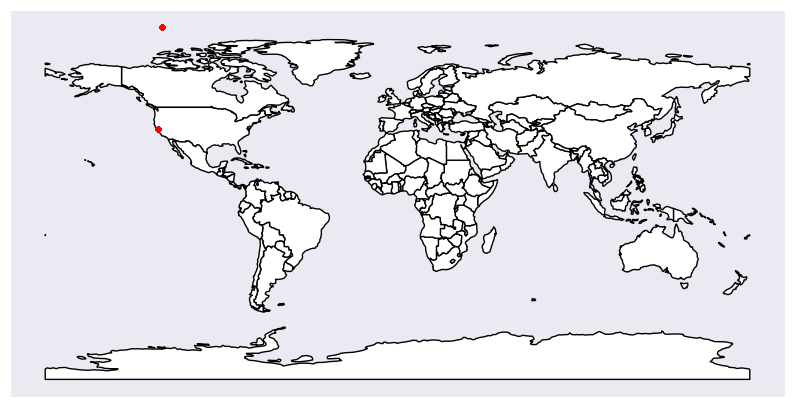

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns

def create_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs='epsg:4326')
    return gdf


crime_gdf = create_gdf(crime)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(10, 10))

world.plot(ax=ax, color='white', edgecolor='black')
crime_gdf.plot(ax=ax, color='red', markersize=10)  # Adjust markersize as needed

ax.set_aspect('equal')

#sns.despine(ax=ax, left=True, right=True, top=True, bottom=True)

ax.set_xticks([])  # Use set_xticks to hide x-axis ticks
ax.set_yticks([])  # Use set_yticks to hide y-axis ticks


plt.show()


Ein Blick auf die Karte genügt um zu sehen, dass sich einige Punkte außerhalb der USA und außerhalb von San Fransisco befinden. Diese Punkte werden konkret lokalisiert und im nächsten Schritt ausgegeben. 

In [11]:
print(crime_gdf.loc[crime_gdf.Y > 50].count()[0])
crime_gdf.loc[crime_gdf.Y > 50].sample(5)

29


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,Year,Month,Day,TimeOfDay,geometry
754828,2004-08-21 23:35:00,LARCENY/THEFT,ATTEMPTED THEFT FROM LOCKED VEHICLE,Saturday,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90.0,2004-08,2004,08,21,23,POINT (-120.50000 90.00000)
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,2005-12,2005,12,30,00,POINT (-120.50000 90.00000)
772431,2004-05-28 18:00:00,VEHICLE THEFT,"VEHICLE, RECOVERED, OTHER VEHICLE",Friday,SOUTHERN,NONE,BRYANT ST / SPEAR ST,-120.5,90.0,2004-05,2004,05,28,18,POINT (-120.50000 90.00000)
759397,2004-08-03 19:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,LARKIN ST / AUSTIN ST,-120.5,90.0,2004-08,2004,08,03,19,POINT (-120.50000 90.00000)
687527,2005-08-13 17:00:00,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Saturday,TENDERLOIN,NONE,JENNINGS CT / INGALLS ST,-120.5,90.0,2005-08,2005,08,13,17,POINT (-120.50000 90.00000)


Zusammengefasst gibt der Code also die Anzahl der Datensätze mit einer Y-Koordinate größer als 50 aus und zeigt dann fünf zufällige Datensätze mit dieser Bedingung an. Dies könnte darauf hindeuten, dass es im GeoDataFrame einige Datensätze mit ungewöhnlichen oder fehlerhaften geografischen Koordinaten gibt. Damit diese auffälligen Daten nicht aus der Analyse ausgeschlossen werden, können die Mittelwerte der vorhandenen Koordinaten der jeweiligen Polizeidistrikte genutzt werden.

In [12]:
crime.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in crime['PdDistrict'].unique():
    crime.loc[crime['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        crime.loc[crime['PdDistrict'] == district, ['X', 'Y']])

crime_gdf = create_gdf(crime)

Es wird folglich für jedes einzigartige Polizeidistrikt ('PdDistrict') im DataFrame crime der Imputer verwendet, um fehlende Werte in den Spalten 'X' und 'Y' durch den Mittelwert der vorhandenen Werte im jeweiligen Distrikt zu ersetzen.

## Fehlende Werte

In [13]:
crime.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
YearMonth     0
Year          0
Month         0
Day           0
TimeOfDay     0
dtype: int64

In [14]:
if sum(crime.isnull().any()*1):
    print("Es gibt fehlende Daten.")
else:
    print("Es gibt keine fehlenden Daten")

Es gibt keine fehlenden Daten


Nachdem die Koordinaten bereinigt wurden, werden weitere fehlende Werte berücksichtigt. Dafür wird die obenstehende Funktion verwendet um die Anzahl der fehlenden Werte in jedem Attribut (Spalte) des DataFrames zu zählen.

Wie aus der Tabelle abgelesen werden kann, gibt es für alle Kategorien keine fehlenden Werte. 




# 5. Exploration

Nachdem die Datenbereinigung abgeschlossen wurde, wird nun der Fokus auf die Exploration der Daten gelegt. Hierbei handelt es sich um einen Prozess, bei dem der Datensatz analysiert wird, um ein besseres Verständnis für die enthaltenen Variablen zu entwickeln. Ziel ist es, Muster, Trends oder ungewöhnliche Beobachtungen zu identifizieren. Dieser Prozess hilft bei der Vorbereitung der Daten für die weitere Analyse und Modellbildung.

## Deskriptive Statistik

### Balkendiagramme

#### Verbrechen je Bezirk

In [15]:
data_cat = crime.groupby('Category').count().iloc[:, 0]. sort_values(ascending=False)
data = data_cat.reindex(np.append(np.delete(data_cat.index, 1), 'OTHER OFFENSES'))



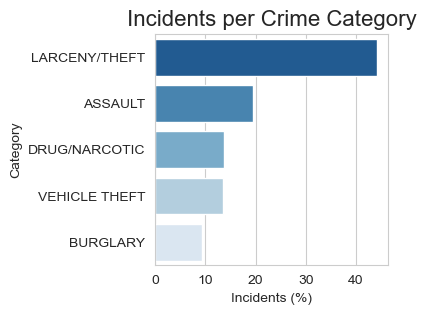

In [16]:
plt.figure(figsize=(3, 3))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x = (data_cat.values / data_cat.values.sum()) * 100,
        y = data_cat.index,
        orient='h',
        palette="Blues_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

Für einen ersten Überblick werden Einzelfälle pro Kategorie in Prozent aufgeschlüsselt. Es ist deutlich zu erkennen, dass 'Larceny/Theft' nahezu 50 Prozent der Fälle ausmacht. Dahingegen werden nur knapp unter 10 Prozent der Fälle als 'Burglary' klassifiziert.'

In [17]:
data_cat.describe()

count         5.000000
mean      79072.000000
std       55129.968488
min       36600.000000
25%       53706.000000
50%       53919.000000
75%       76815.000000
max      174320.000000
Name: Dates, dtype: float64

Für die weitere Einordnung wird die Funktion describe() genutzt. Wie bereits in der Selektion deutlich wurde, wird in der Analyse nur mit den fünf ausgewählten Kategorien gearbeitet. Außerdem können einige grundlegende statistische Maße abgelesen werden.

### Histogramme

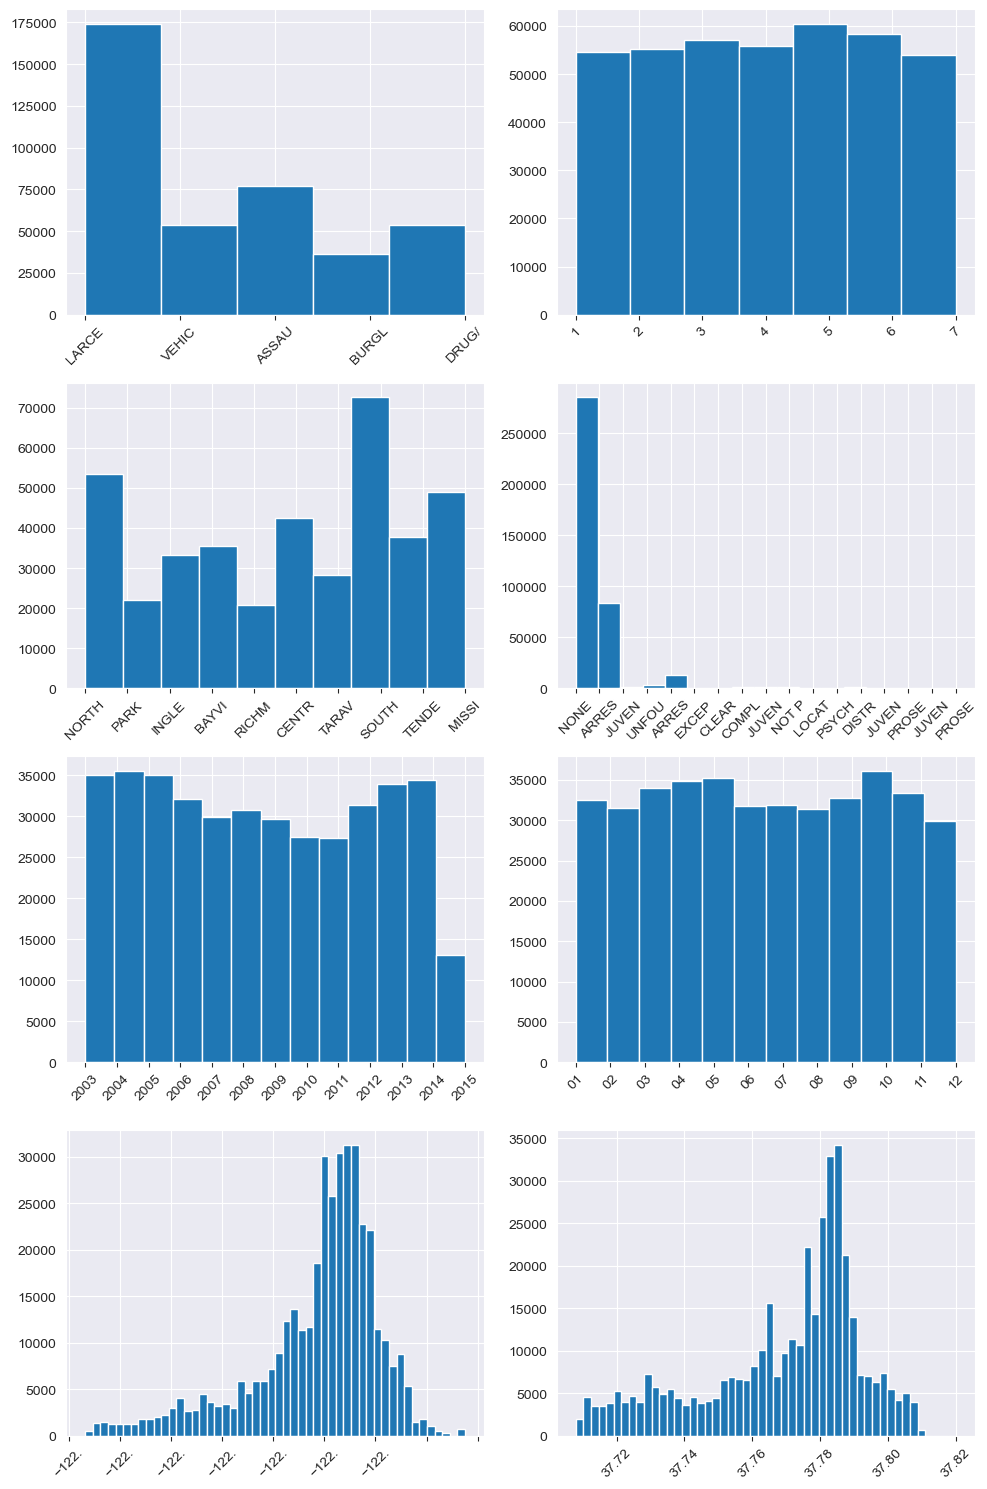

In [18]:


def truncate_label(label, length=5):
    return label[:length]

colors = sns.color_palette(None, 3)
columns = ["DayOfWeek", "PdDistrict", "Resolution"]


fig, axes = plt.subplots(4, 2, figsize = (10, 15), tight_layout=True)

axes[0, 0].hist(crime["Category"], bins=5, align="mid")

#Tag der Woche als Zahl für Sortierung der Balken
axes[0, 1].hist(crime['Dates'].dt.weekday + 1, bins=7, align="mid")

axes[1, 0].hist(crime["PdDistrict"], bins=len(crime["PdDistrict"].unique()))
axes[1, 1].hist(crime["Resolution"], bins=len(crime["Resolution"].unique()))
axes[2, 0].hist(crime["Year"].sort_values(), bins=13)
axes[2, 1].hist(crime["Month"].sort_values(), bins=12)
axes[3, 0].hist(crime["X"], bins=50)
axes[3, 1].hist(crime["Y"], bins=50)

# Rotate x-axis tick labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_ticks_position('bottom')  # Place ticks at the bottom for better visibility
    ax.set_xticklabels([truncate_label(label.get_text()) for label in ax.get_xticklabels()])

plt.tight_layout()

plt.show()

Hier werden Histogramme für verschiedene Merkmale des Kriminalitätsdatensatzes erstellt, einschließlich der Kategorie der Straftaten, dem Wochentag, dem Polizeibezirk, der Auflösung, dem Jahr, dem Monat sowie den geografischen Koordinaten X und Y. 

### Zeitliche Regression

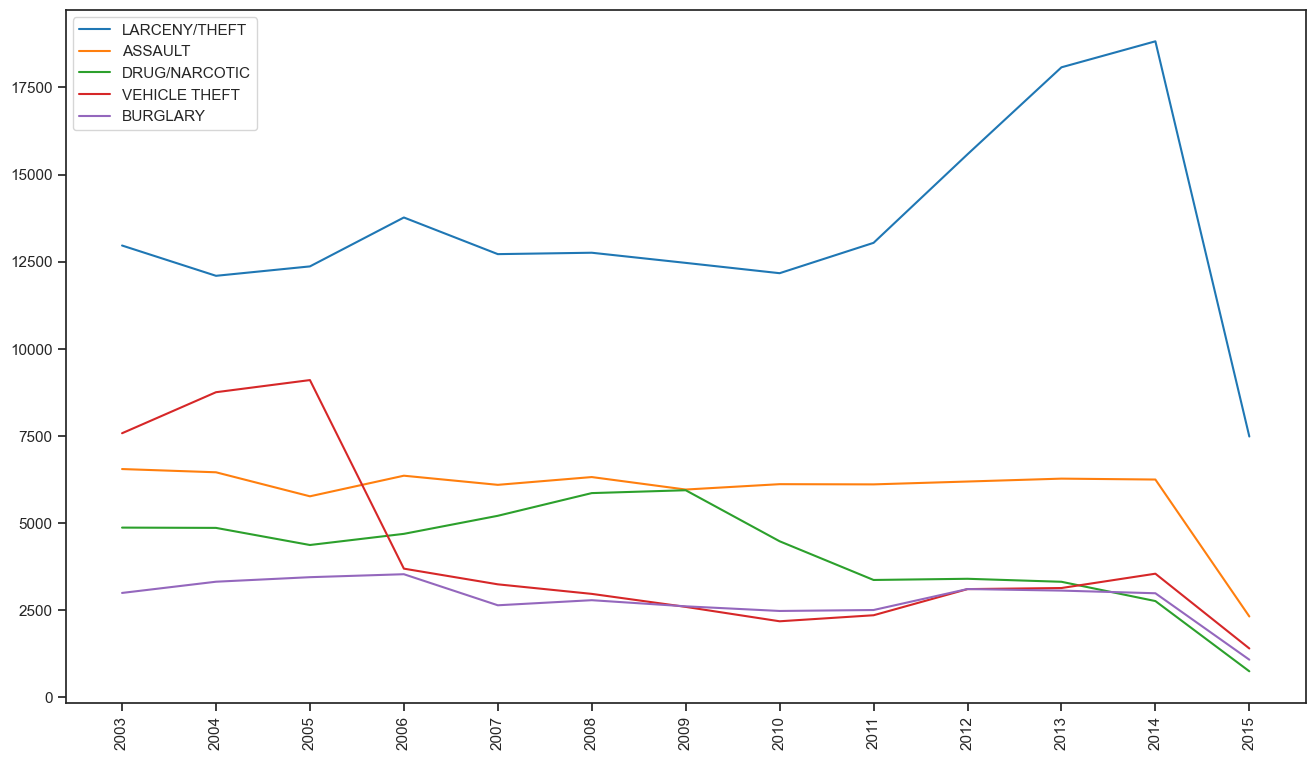

In [19]:
sns.set_style("ticks")
sns.set_context('notebook', font_scale = 1)

crime_year_cat = crime.groupby(by=["Year", "Category"], as_index=False).count()
data = crime_year_cat.pivot_table(index="Year", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix, rotation=90, ha="center")
plt.show()


Es folgt eine Visualising der zeitlichen Regression und Entwicklung der Straftaten in verschiedenen Kategorien über die Jahre gruppiert nach 'Year', wodurch Trends und Muster im zeitlichen Verlauf sichtbar werden. Besonders Auffällig ist der Abfall von 'Larceny/Theft' nach dem Jahr 2014. 

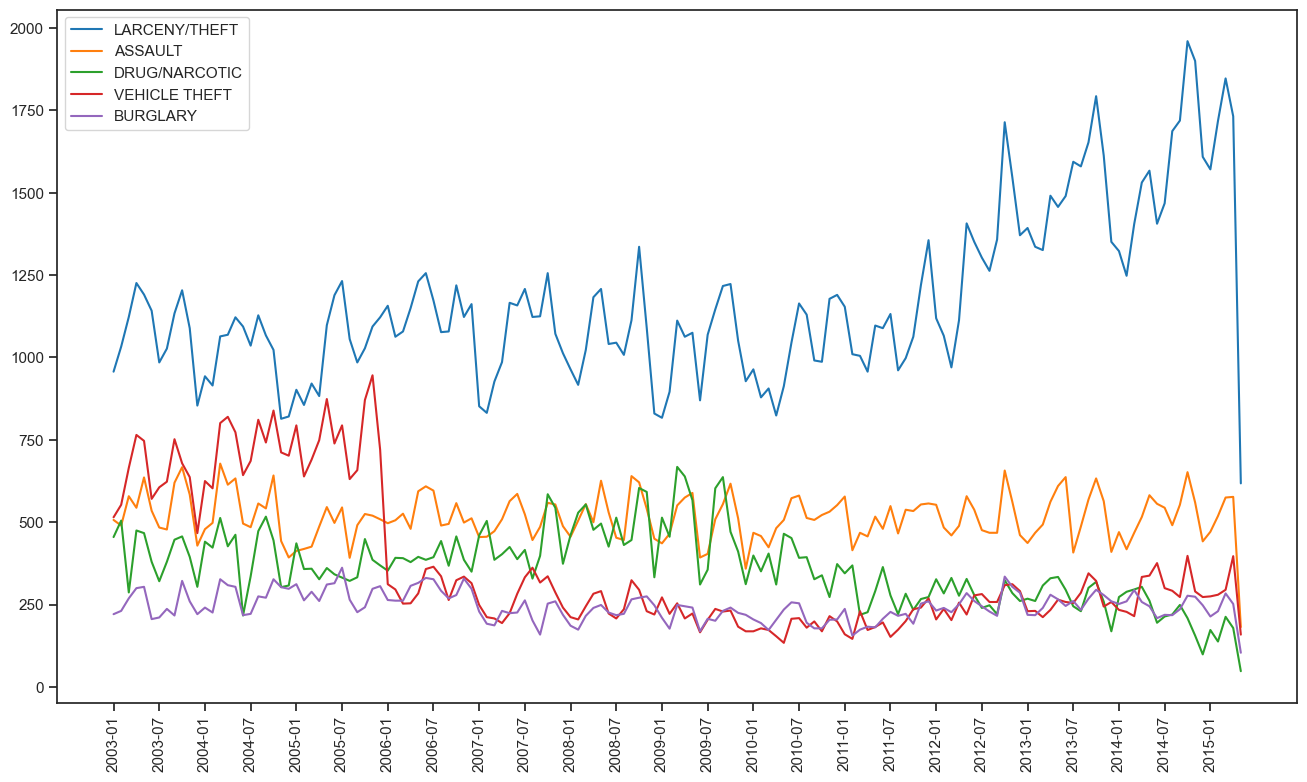

In [20]:
crime_yearmonth_cat = crime.groupby(by=["YearMonth", "Category"], as_index=False).count()
data = crime_yearmonth_cat.pivot_table(index="YearMonth", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix[::6], rotation=90, ha="center")
plt.show()

Diese Visualisierung zeigt ebenfalls die zeitliche Entwicklung der Straftaten nach den jeweiligen Kategorien. In diesem Fall wird jedoch eine Gruppierung nach 'YearMonth' vorgenommen, damit eine feinere zeitliche Auflösung ersichtlich wird. 

### Kartogramme

In [21]:

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})

geometry = [Point(xy) for xy in zip(crime.X, crime.Y)]
crime_gdf = GeoDataFrame(crime, crs="EPSG:4326", geometry=geometry)


point = crime_gdf
poly  = sf_df

pointInPolys = sjoin(point, poly, how='left')
grouped = pointInPolys.groupby('index_right').count()


Hier wird eine GeoDataFrame (sf_df) aus einer GeoJSON-Datei eingelesen, die die Grenzen der Stadtviertel von San Francisco enthält. Die to_crs-Methode wird verwendet, um die Koordinatenreferenz des GeoDataFrames auf das Standardformat (EPSG:4326) zu ändern, das Längen- und Breitengrade verwendet. 
Vgl. City and County of San Francisco. (2016). SF Find Neighborhoods. [Dataset]. Socrata. https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4

Insgesamt ermöglicht dieses Vorgehen die Zuordnung von Kriminalitätsdaten zu den entsprechenden Stadtvierteln von San Francisco und die Berechnung der Anzahl der Vorkommen in jedem Viertel. Dies ist nützlich, um räumliche Muster und Hotspots von Kriminalität zu identifizieren.

In [22]:
heat_districts = pointInPolys.groupby('index_right')["Dates"].count()
heat_districts

index_right
0.0       239
1.0       450
2.0        36
3.0       465
4.0      5046
         ... 
112.0     579
113.0     591
114.0    1664
115.0     226
116.0     191
Name: Dates, Length: 117, dtype: int64

In heat_districts werden dafür Indexwerte für die einzelnen Stadtviertel erstellt. Die Werte repräsentieren dabei die Anzahl der Kriminalitätsvorfälle in jedem Stadtviertel.

In [23]:

geom = sf_df.pop('geometry')
sf_df = sf_df.join(geom, how='inner')
sf_df["polygons"] = ""
for i,row in sf_df.iterrows():
    geometry = row["geometry"]
    if geometry.geom_type == 'MultiPolygon':
        polygons = []
        for polygon in geometry.geoms:
            exterior_coords = list(polygon.exterior.coords)
            interior_coords = [list(interior.coords) for interior in polygon.interiors]
            polygons.append(Polygon(exterior_coords, interior_coords))
    else:
        polygons = [Polygon(list(geometry.exterior.coords))]
    sf_df.at[i, "polygons"] = polygons

sf_df["polygons"] = sf_df["polygons"].explode()

sf_df["index_right"] = sf_df.index
sf_df["heat"] = sf_df.merge(heat_districts, on="index_right")["Dates"]
sf_df["geometry"] = sf_df["polygons"]

gdf = gpd.GeoDataFrame(sf_df)




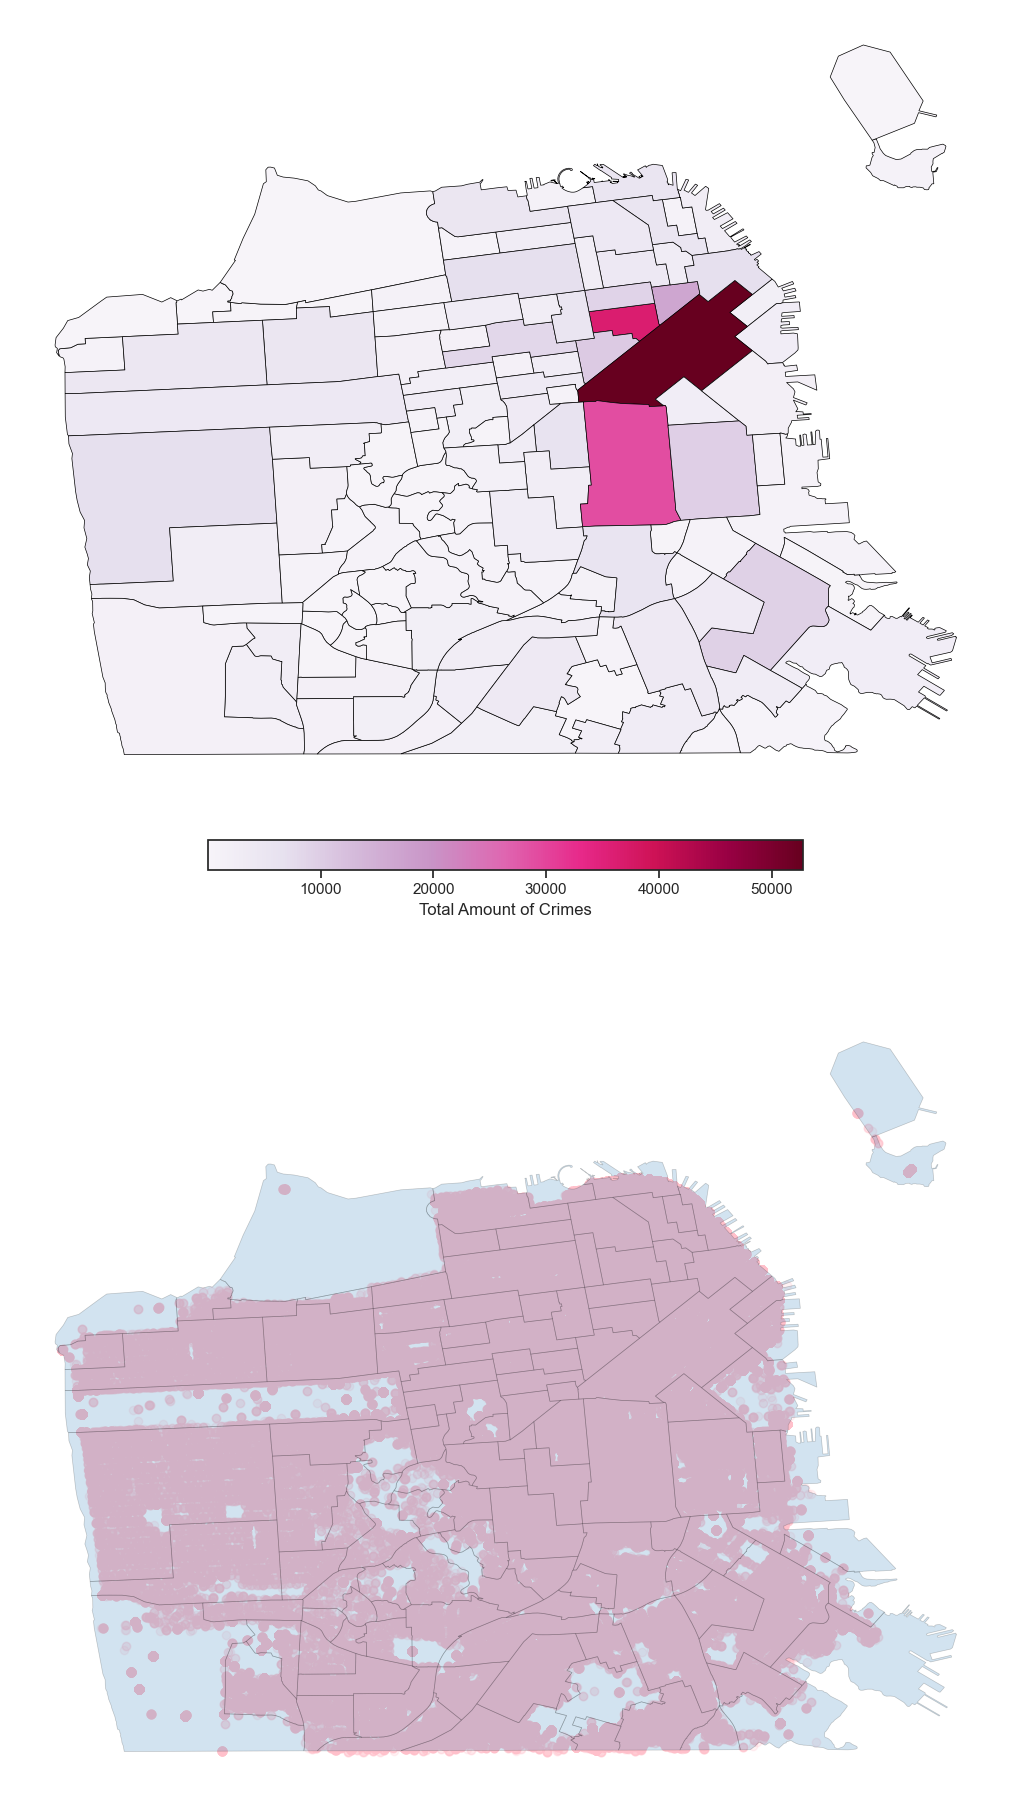

In [24]:
fig, ax = plt.subplots(2,1,figsize=(10, 20), layout='constrained')

gdf.plot(ax=ax[0], alpha=1, edgecolor='k', linewidth=0.5, column="heat", cmap="PuRd")
cbar = plt.colorbar(ax[0].get_children()[0], ax=ax[0], orientation="horizontal", shrink=0.6)
cbar.set_label("Total Amount of Crimes")

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})
sf_df.plot(ax=ax[1], alpha=0.2, edgecolor='k', linewidth=0.5, zorder=2)
ax[1].scatter(data=crime.loc[crime["Y"]<80], x="X", y="Y",alpha=0.2, color="pink", zorder=1)

ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

sns.despine(ax=ax[0], left=True, right=True, top=True, bottom=True)
sns.despine(ax=ax[1], left=True, right=True, top=True, bottom=True)

ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])

ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])    
    
plt.show()



Insgesamt kann in der Heat-Map ein deutliches Muster erkannt werden. Die Kriminalfälle bündeln sich besonders in den Stadtvierteln im Nord-Osten von San Francisco.

## Feature Engineering

An dieser Stelle werden neue Spalten generiert, die den Datensatz bereichern und den Modellen helfen können.

### Feiertage

Zuerst werden die US-Feiertage importiert und dem Datensatz hinzugefügt.

In [25]:
import holidays

usa_holidays = pd.Series(holidays.country_holidays('US',  years=range(crime["Dates"].dt.year.min(), crime["Dates"].dt.year.max())))

usa_holidays = pd.DataFrame(usa_holidays)
usa_holidays.columns = ["Holiday"]
usa_holidays["YearMonthDay"] = pd.to_datetime(usa_holidays.index)
usa_holidays.reset_index(drop=True)

crime["YearMonthDay"] = pd.to_datetime(crime['Dates'].dt.strftime('%Y-%m-%d'))
crime = crime.merge(usa_holidays, on="YearMonthDay", how="left")

crime["Holiday"].fillna("None", inplace=True)

In [26]:
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,Year,Month,Day,TimeOfDay,YearMonthDay,Holiday
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,2015,05,13,23,2015-05-13,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,2015,05,13,23,2015-05-13,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,2015,05,13,23,2015-05-13,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,2015,05,13,23,2015-05-13,None
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,2015,05,13,23,2015-05-13,None


In [27]:
df_district_holiday = pd.crosstab(crime['Category'], crime['Holiday'])
df_district_holiday = df_district_holiday.loc[:, df_district_holiday.columns != 'None']
df_district_holiday.head()

Holiday,Christmas Day,Christmas Day (Observed),Columbus Day,Independence Day,Independence Day (Observed),Labor Day,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Day (Observed),Thanksgiving,Veterans Day,Veterans Day (Observed),Washington's Birthday
Category,,,,,,,,,,,,,,
ASSAULT,201,86,185,42,43,386,179,378,198,37,170,191,52,335
BURGLARY,117,47,110,16,13,102,92,151,45,10,98,80,34,166
DRUG/NARCOTIC,65,32,166,11,13,272,202,271,54,13,86,175,43,313
LARCENY/THEFT,368,183,516,57,60,726,458,687,241,76,319,463,157,753
VEHICLE THEFT,153,90,146,17,42,218,133,217,43,14,111,159,32,250


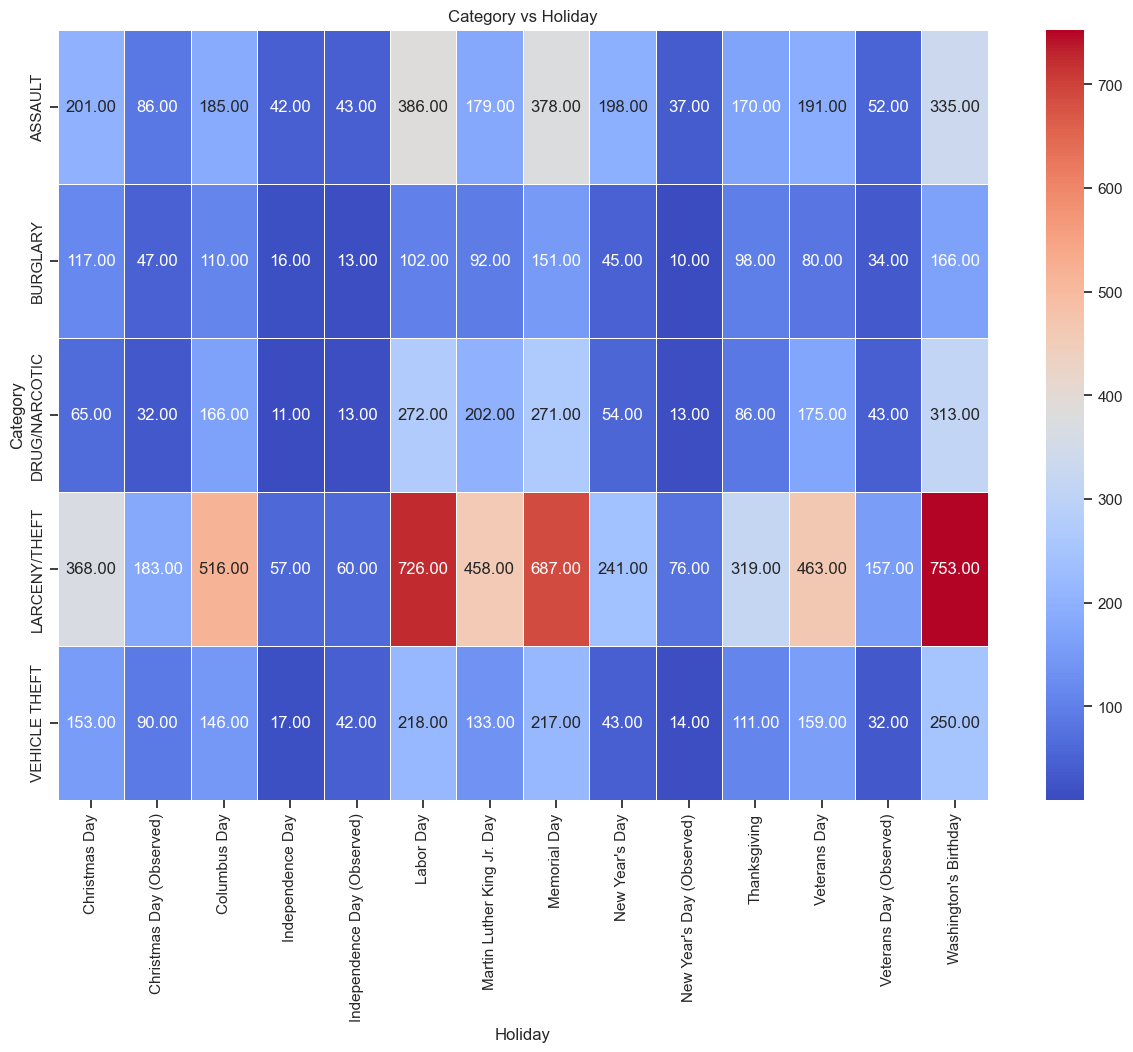

In [28]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_district_holiday, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Category vs Holiday')
plt.show()

In dieser Heat-Map werden die Feiertage den Kriminalkategorien entgegengestellt. Hier lässt sich ablesen, dass es die meisten Verbechen am Labor Day und Washingtons Birthday gibt.

### Wetter

Die Daten werden um ein weiteres Feature erweitert. Heirfür werden die Wetterdaten für die entsprechende Region importiert.

In [29]:
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,Year,Month,Day,TimeOfDay,YearMonthDay,Holiday
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,2015,05,13,23,2015-05-13,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,2015,05,13,23,2015-05-13,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,2015,05,13,23,2015-05-13,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,2015,05,13,23,2015-05-13,None
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,2015,05,13,23,2015-05-13,None


In [30]:
crime["hours"] = pd.to_datetime(crime['Dates'].dt.strftime('%Y-%m-%d %H'))

In [31]:
from meteostat import Point, Hourly
import pandas as pd
import matplotlib.pyplot as plt

start_date = crime['Dates'].min()
end_date = crime['Dates'].max()

san_francisco = Point(37.7749, -122.4194, 10)

# Get hourly data for the specified date range
sf_weather = pd.DataFrame(Hourly(san_francisco, start_date, end_date).fetch())

sf_weather["hours"] = pd.to_datetime(sf_weather.index.strftime('%Y-%m-%d %H'))
crime = crime.merge(sf_weather, how="left", on="hours")

In [32]:
crime.describe()

,Dates,X,Y,YearMonthDay,hours,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
count,395360,395360.000000,395360.000000,395360,395360,395354.000000,395354.000000,395354.000000,391008.000000,0.0,378674.000000,395354.000000,0.0,395354.000000,0.0,0.0
mean,2009-02-10 07:21:34.632638464,-122.422927,37.768872,2009-02-09 17:05:35.087009024,2009-02-10 07:03:04.261432832,14.355385,9.080500,72.988772,0.052628,NaN,229.155712,12.871729,NaN,1017.067777,NaN,NaN
min,2003-01-06 00:01:00,-122.513642,37.707920,2003-01-06 00:00:00,2003-01-06 00:00:00,-1.700000,-15.800000,8.000000,0.000000,NaN,10.000000,0.000000,NaN,995.700000,NaN,NaN
25%,2005-10-22 22:56:15,-122.433010,37.755456,2005-10-22 00:00:00,2005-10-22 22:45:00,11.700000,6.800000,63.000000,0.000000,NaN,180.000000,7.600000,NaN,1013.900000,NaN,NaN
50%,2008-12-25 01:32:30,-122.416650,37.776044,2008-12-25 00:00:00,2008-12-25 01:00:00,14.000000,9.900000,75.000000,0.000000,NaN,260.000000,11.200000,NaN,1016.700000,NaN,NaN
75%,2012-06-25 18:18:45,-122.407149,37.785103,2012-06-25 00:00:00,2012-06-25 18:00:00,17.200000,12.000000,86.000000,0.000000,NaN,290.000000,18.400000,NaN,1020.000000,NaN,NaN
max,2015-05-13 23:30:00,-122.364937,37.819975,2015-05-13 00:00:00,2015-05-13 23:00:00,36.700000,21.100000,100.000000,14.200000,NaN,360.000000,64.800000,NaN,1034.800000,NaN,NaN
std,NaN,0.025085,0.023804,NaN,NaN,4.611076,4.073984,16.490254,0.386137,NaN,86.096953,9.063958,NaN,4.664423,NaN,NaN


<Axes: xlabel='temp'>

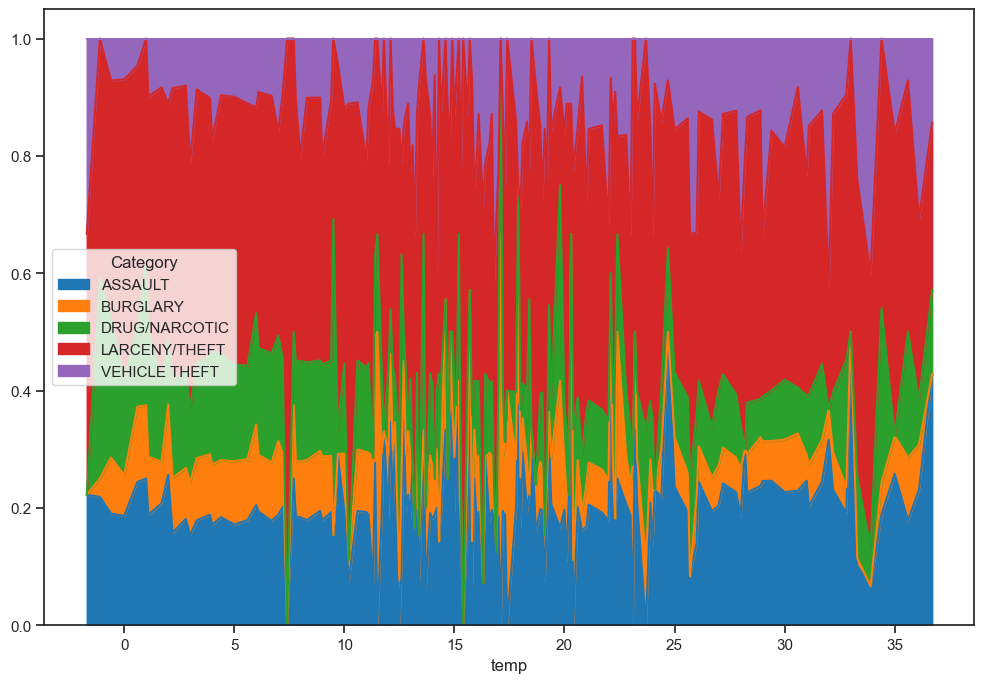

In [33]:
temp_cat_ct = pd.crosstab(crime["temp"], crime["Category"],  normalize='index')
temp_cat_ct.plot(kind="area",  stacked="true", figsize=(12, 8))

### Straßen

Außerdem werden Straßen dem Datensatz hinzugefügt. Ziel ist es eine Übersicht der *gefährlichsten* Straßen in San Francisco zu bekommen.

In [34]:
is_block = crime["Address"].str.contains(" /")
crime.loc[is_block, "Street/Block"] = crime.loc[is_block, "Address"].copy()
crime.loc[is_block, "Street_1"] = crime.loc[is_block, "Address"].apply(lambda x: x.split(" /")[0]).copy()
crime.loc[is_block, "Street_2"] = crime.loc[is_block, "Address"].apply(lambda x: x.split(" /")[1]).copy()

is_street = crime["Address"].str.contains(" of ")
crime.loc[is_street, "Street/Block"] = crime.loc[is_street, "Address"].apply(lambda x: x.split(" of ")[1]).copy()
crime.loc[is_street, "Street_1"] = crime.loc[is_street, "Address"].apply(lambda x: x.split(" of ")[1]).copy()
crime.loc[is_street, "Street_2"] = None
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,...,snow,wdir,wspd,wpgt,pres,tsun,coco,Street/Block,Street_1,Street_2
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,LOMBARD ST,LOMBARD ST,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,BRODERICK ST,BRODERICK ST,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,TEDDY AV,TEDDY AV,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,AVALON AV / PERU AV,AVALON AV,PERU AV
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,KIRKWOOD AV / DONAHUE ST,KIRKWOOD AV,DONAHUE ST


In [35]:
crime["Street/Block"].unique()

array(['LOMBARD ST', 'BRODERICK ST', 'TEDDY AV', ...,
       'ALERT AL / DOLORES ST', 'FOLSOM ST / ZENO PL',
       '35TH AV / ANZA ST'], dtype=object)

In [36]:
str_cat_ct = pd.crosstab(crime["Street/Block"], crime["Category"], margins=True, margins_name="Total")

str_cat_ct = str_cat_ct[str_cat_ct.index != "Total"]
top_ten_str = str_cat_ct.sort_values(by="Total", ascending=False).head(10)
top_ten_str

Category,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,VEHICLE THEFT,Total
Street/Block,,,,,,
MARKET ST,2190,1245,2270,7660,196,13561
MISSION ST,2932,849,3061,3861,493,11196
BRYANT ST,2086,555,821,6681,313,10456
TURK ST,1181,265,2421,657,154,4678
OFARRELL ST,821,498,725,2376,249,4669
ELLIS ST,1027,231,1904,733,143,4038
EDDY ST,1379,329,1015,801,139,3663
POST ST,408,418,216,1793,162,2997
POWELL ST,470,264,113,2067,61,2975


Anhand der Tabelle wird deutlich, dass bei den Top drei der gefährlichsten Straßen mit den meisten Kriminalfällen um die Market St, Mission St und Bryant St handelt. Hierbei ist jedoch die Länge der Straße zu beachten, damit diese Werte in ein geeignetes Verhältnis gesetzt werden können. Einige Straßen reichen durch nahezu die komplette Stadt, während andere kurz bemessen sind.

Zuletzt folgt die Visualisierung der Straßen anhand von einem Balkendiagramm.

<Axes: xlabel='Street/Block'>

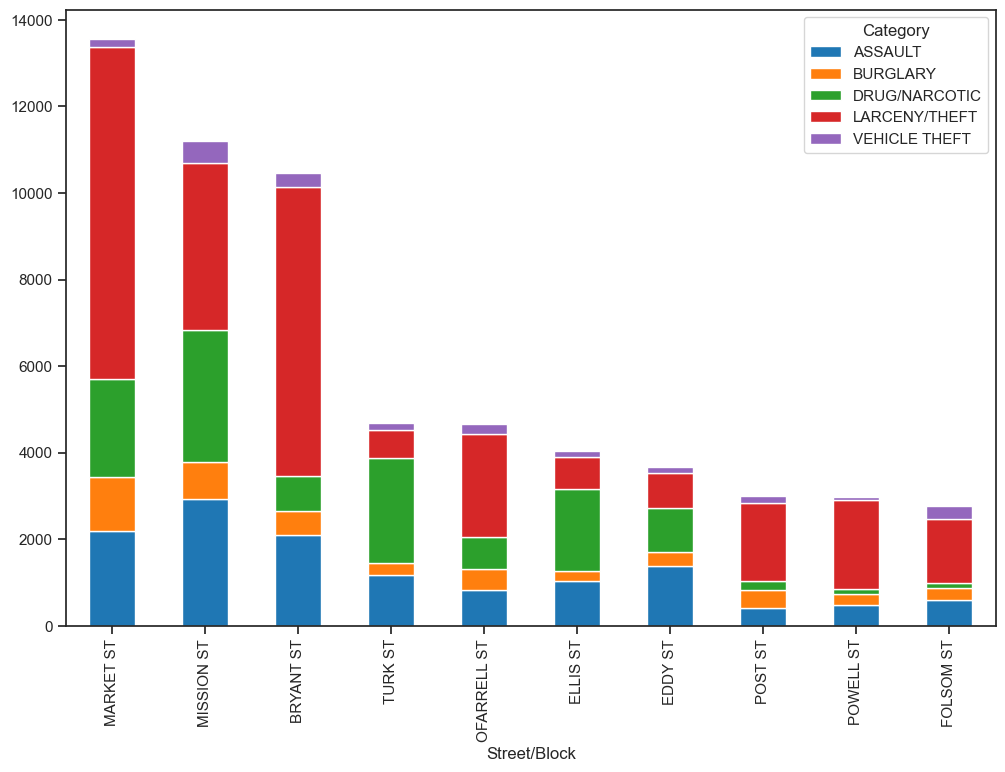

In [37]:
top_ten_str.drop('Total', axis=1).plot(kind='bar', stacked=True, figsize=(12, 8))

### Korrelation

Nachfolgend werden weitere Korrelationen berechent und visualisiert, um erneut Muster und Zusammenhänge in den Daten zu erkennen.

#### Korrelation zwischen Kategorien und Bezirken

Dafür wird im ersten Schritt eine Kreuztabelle für den Bezirk und die Kategorie erstellt.

In [38]:
df_district_cat = pd.crosstab(crime['Category'], crime['PdDistrict'])
df_district_cat.head()

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ASSAULT,9845,6971,8522,11146,8312,3512,3198,12175,5460,7674
BURGLARY,3914,4499,3327,3736,5827,2875,2683,4796,3459,1484
DRUG/NARCOTIC,4496,1805,2372,8750,4508,2570,999,9222,1529,17668
LARCENY/THEFT,10075,24973,10207,18201,28566,9118,9845,41660,11807,9868
VEHICLE THEFT,7199,4208,8950,7134,6286,3955,4114,4722,6133,1005


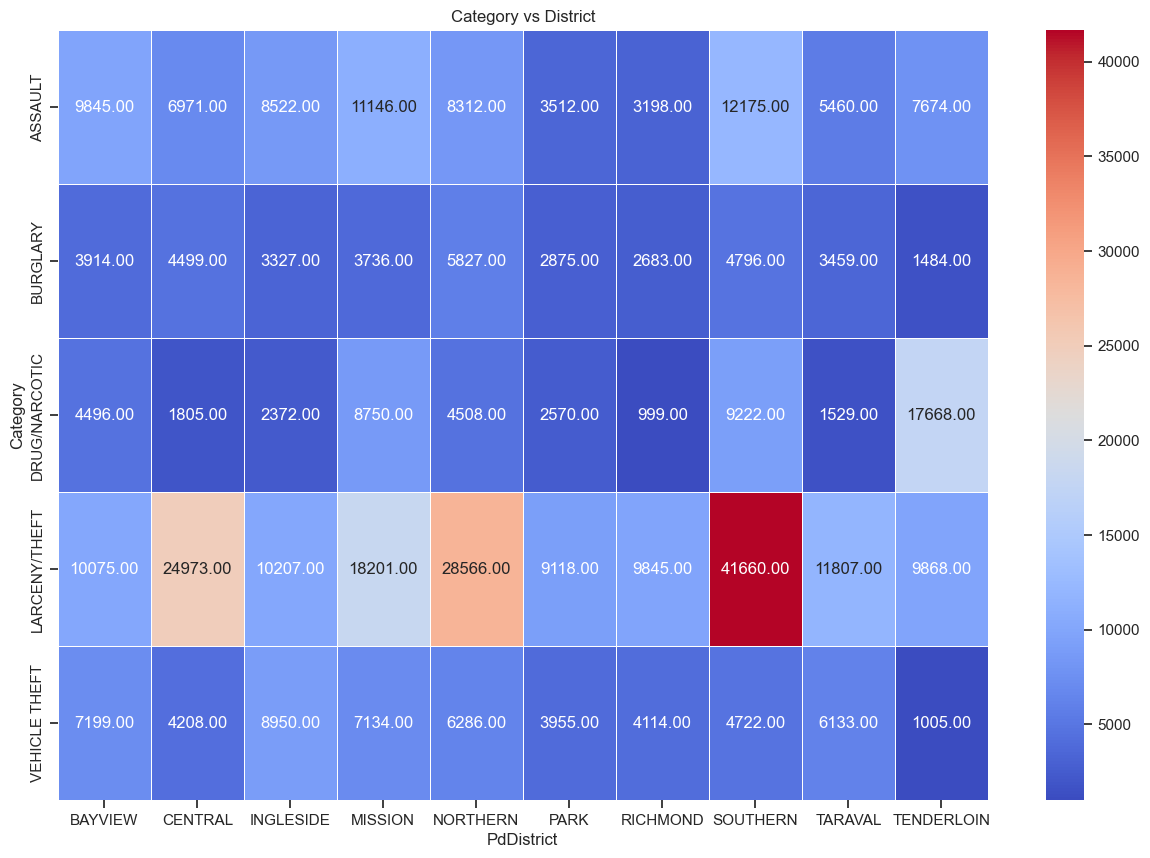

In [39]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_district_cat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Category vs District')
plt.show()

Anhand dieser Heat-Map wird ersichtlich, dass es besonders im Bezitk 'Southern' ein hohes Aufkommen von 'Larceny/Theft'-Kriminalfällen gibt.

#### Korrelation zwischen den kategorischen Spalten

Für die weitere Betrachtung wird die Korrelation zwischen den kategorischen Spalten betrachtet.

In [40]:
unique_val_col = pd.DataFrame(crime.nunique())
corr_columns = list(unique_val_col.loc[(unique_val_col[0] > 0) & (unique_val_col[0] <= 15000)].index)
print(corr_columns)

['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'YearMonth', 'Year', 'Month', 'Day', 'TimeOfDay', 'YearMonthDay', 'Holiday', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'Street/Block', 'Street_1', 'Street_2']


In [41]:

x = [i[0] for i in product(corr_columns, corr_columns)]
y = [i[1] for i in product(corr_columns, corr_columns)]


corr_df = pd.DataFrame(index=corr_columns, columns=corr_columns)

for i in range(0,len(x)):
    if x[i] == y[i]:
        corr_df.loc[x[i], y[i]] = 1
        corr_df.loc[y[i], x[i]] = 1
    if pd.isnull(corr_df.loc[x[i], y[i]]):
        temp_ct = pd.crosstab(crime[x[i]], crime[y[i]])

        X2 = stats.chi2_contingency (temp_ct, correction= False )[0]
        n = sum(temp_ct.sum())
        minDim = min( temp_ct.shape )-1

        V = np.sqrt((X2/n) / minDim)

        corr_df.loc[x[i], y[i]] = V
        corr_df.loc[y[i], x[i]] = corr_df.loc[x[i], y[i]]

Hierfür wurde die Berechnung von Cramers-V genutzt.

Vgl. Cramér, H. (1946). Mathematical Methods of Statistics. Princeton: Princeton University Press, p. 282 (Chapter 21. The two-dimensional case). ISBN 0-691-08004-6.

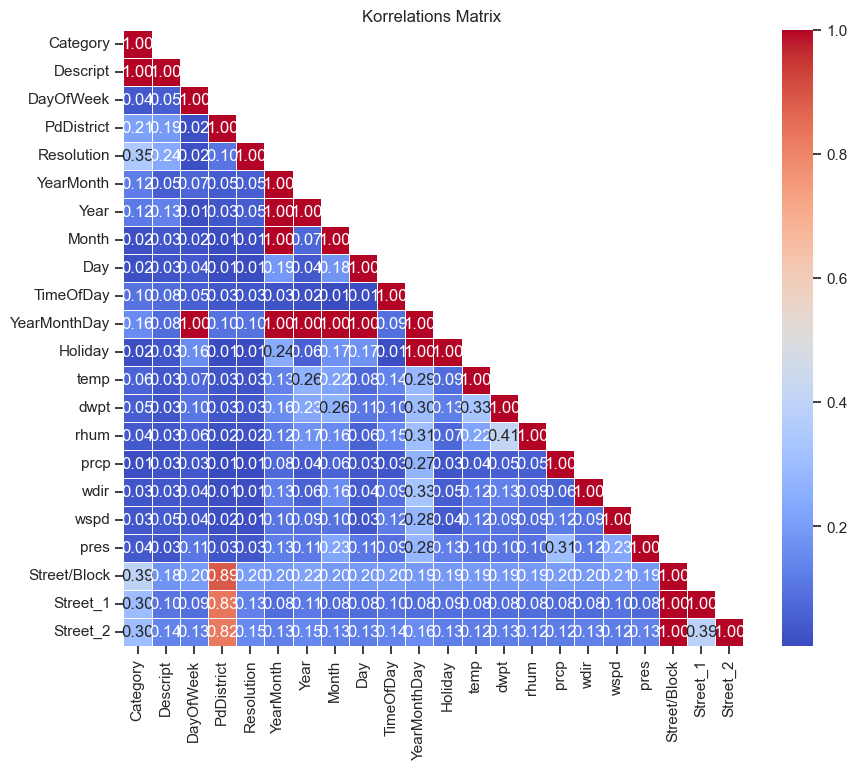

In [42]:
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Korrelations Matrix ')
plt.show()

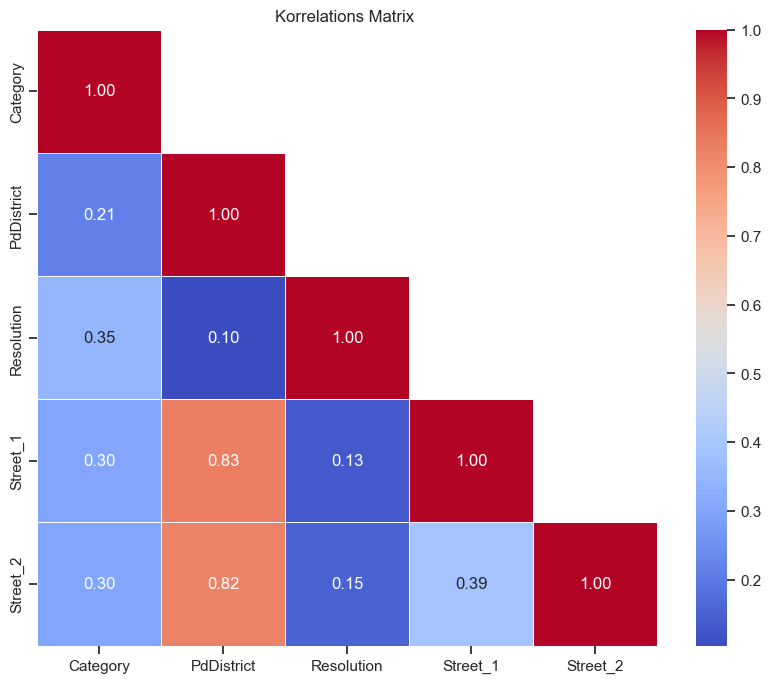

In [43]:
__corr_df = corr_df.loc[corr_df["Category"] >= 0.09]
__corr_df = __corr_df.drop(["YearMonth", "Year", "Descript", "YearMonthDay", "TimeOfDay", "Street/Block"])
__corr_df = __corr_df.apply(pd.to_numeric, errors='coerce')
__corr_df = __corr_df[__corr_df.index]

mask = np.zeros_like(__corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(__corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Korrelations Matrix ')
plt.show()

Insgesamt ermöglicht diese Heatmap eine visuelle Darstellung der Korrelationsmatrix. Durch die Farben und die annotierten Werte können leicht Muster und Stärke der Korrelationen zwischen den verschiedenen Variablen im Datensatz erkannt werden.

# 6. Vorbereitung

Anhand der Korrelation können wir ablesen, welche Spalten den größten Einfluss auf die Kategorie hat, welche wir letztendlich vorhersagen wollen.

In [44]:
__corr_df["Category"]


Category      1.000000
PdDistrict    0.213927
Resolution    0.346102
Street_1      0.302386
Street_2      0.302562
Name: Category, dtype: float64

Im nächsten Schritt werden die Spalten ausgewählt, welche mindestens eine Korrelation von 0.05 haben


Da Year und YearMonth fast die gleiche Korrelation mit Category haben und untereinander eine sehr hohe Korrelation haben, 
beschränken wir uns auf YearMonth und filtern Year raus. 

<!-- Resolution ist leider nicht in den Test-Daten vorhanden, daher nützt es nichts die Modelle mit dieser Spalte zu trainieren und sie wird ebenfalls entfernt.  -->

Und da wir Category vorhersagen sollen, wird es auch im Training nicht berücksichtigt

In [45]:
onehot_cols = __corr_df.index


#Obwohl Resolution für die Kaggle-Challange nicht verwendet werden darf, darf es im Rahmen des Projekts zur Klassifikation dienen.
#onehot_cols.remove("Resolution")


onehot_cols = onehot_cols.drop("Category")
onehot_cols

Index(['PdDistrict', 'Resolution', 'Street_1', 'Street_2'], dtype='object')

## One-Hot-Encoding

In [46]:
crime_dummies = pd.get_dummies(data=crime, columns=onehot_cols, dtype=float, prefix=["_" + i for i in onehot_cols])
crime_dummies["Category"] = crime["Category"]
crime_dummies.head()

,Dates,Category,Descript,DayOfWeek,Address,X,Y,YearMonth,Year,Month,...,_Street_2_ YERBA BUENA AV,_Street_2_ YERBABUENA AV,_Street_2_ YORBA ST,_Street_2_ YORK ST,_Street_2_ YOSEMITE AV,_Street_2_ YUKON ST,_Street_2_ ZAMPA LN,_Street_2_ ZENO PL,_Street_2_ ZIRCON PL,_Street_2_ ZOE ST
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# from sklearn.preprocessing import OneHotEncoder
# import pandas as pd
# 
# # Assuming 'crime' is your DataFrame and 'onehot_cols' is a list of columns to be one-hot encoded
# 
# # Extract the columns you want to one-hot encode
# onehot_data = crime[onehot_cols]
# 
# # Initialize OneHotEncoder
# ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
# 
# # Fit and transform the data
# onehot_encoded = ohe.fit_transform(onehot_data)
# 
# # Create a DataFrame with the one-hot encoded values
# enc_df = pd.DataFrame(onehot_encoded, columns=ohe.get_feature_names_out(onehot_cols))
# 
# # Concatenate the original DataFrame with the one-hot encoded DataFrame
# crime_dummies_2 = pd.concat([crime, enc_df], axis=1)
# 
# # Drop the original categorical columns if needed
# crime_dummies_2 = crime_dummies_2.drop(columns=onehot_cols)
# 
# # Now 'crime_dummies_2' contains the DataFrame with one-hot encoded columns
# crime_dummies_2.head()

## Aufteilung in Trainings- und Test-Daten

In [48]:
X, y = crime_dummies.filter(like='_', axis=1), crime_dummies["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

NameError: name 'crime' is not defined

# 7. Modellierung

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, dt_clf.predict(X_test))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth" : [2,3,4]}
dt_clf = DecisionTreeClassifier()

CV_dt = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv= 2,verbose=5)
CV_dt.fit(X, y)
CV_dt.cv_results_

In [ ]:
CV_dt.best_params

## Support Vector Machines

In [59]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)

accuracy_score(y_test, svm_clf.predict(X_test))

In [65]:
param_grid = {
    'C': [0.1, 1, 10, 100],       # Regularization parameter
    'loss': ['hinge'],  # Loss function
    'max_iter': [1000],       # Maximum number of iterations
    'tol': [1e-4]             # Tolerance for stopping criteria
}
svm_clf = LinearSVC()

CV_svm = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv= 2,verbose=5)
CV_svm.fit(X, y)
CV_svm.cv_results_

Fitting 2 folds for each of 4 candidates, totalling 8 fits


MemoryError: Unable to allocate 2.89 GiB for an array with shape (1961, 197680) and data type float64

In [62]:
del CV_svm

In [64]:
import gc

# Trigger garbage collection
gc.collect()

5065